# CAT Boost Model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

sns.set_style("whitegrid")

The cleaned and prepared scraped dataset is stored in apartments_final.csv

In [3]:
df = pd.read_csv("apartments_final.csv")

df.head()


,url,listing_id,zipcode,monthly_rent,bedrooms,bathrooms,square_feet,walk_score,transit_score,deposit,latitude,longitude,neighborhood,nbhd
0,https://www.apartments.com/2372-beckwith-dr-in...,ze0jqwy,46218,751,2,1.0,679.0,25,33,705,39.80125,-86.12643,Martindale-Brightwood,Martindale-Brightwood
1,https://www.apartments.com/7491-n-shadeland-av...,s34dq64,46250,1795,3,2.0,2500.0,54,33,1795,39.89034,-86.04540,I-69 Fall Creek,I-69 Fall Creek
2,https://www.apartments.com/nice-3-bedroom-ranc...,n669z9m,46237,1095,3,1.0,1439.0,29,32,1095,39.72238,-86.12113,University Heights,University Heights
3,https://www.apartments.com/1102-n-oakland-ave-...,c4kr5zf,46201,1300,3,1.5,1500.0,67,38,800,39.78265,-86.11278,Near Eastside,Near Eastside
4,https://www.apartments.com/634-e-10th-st-india...,rl2dfp0,46202,1600,2,2.0,1400.0,74,53,1600,39.78089,-86.14610,Chatham Arch,Chatham Arch


In [14]:
df.describe()

,zipcode,monthly_rent,bedrooms,bathrooms,square_feet,walk_score,transit_score,deposit,latitude,longitude,bedXbath,feet_per_room,ft_bath,ft_bed
count,871.000000,871.000000,871.000000,871.000000,871.000000,871.000000,871.000000,871.000000,871.000000,871.000000,871.000000,871.000000,871.000000,871.000000
mean,46222.282434,1283.833525,2.045924,1.564868,1130.678530,37.180253,25.227325,1207.065442,39.791344,-86.148214,3.674512,328.436842,1989.923651,2797.173364
std,31.355223,454.606361,1.121454,0.590232,627.812978,23.783910,17.084812,513.401254,0.079023,0.092329,2.883858,150.285942,1614.959517,2525.750317
min,46038.000000,450.000000,0.000000,1.000000,50.000000,0.000000,0.000000,100.000000,39.626880,-86.341270,0.000000,50.000000,50.000000,0.000000
25%,46211.000000,909.000000,1.000000,1.000000,700.000000,16.000000,14.000000,850.000000,39.748400,-86.214015,1.000000,257.142857,703.000000,705.000000
50%,46224.000000,1202.000000,2.000000,1.500000,1025.000000,37.000000,29.000000,1150.000000,39.795340,-86.143990,3.000000,300.285714,1600.000000,2184.000000
75%,46237.000000,1634.500000,3.000000,2.000000,1390.000000,54.000000,35.000000,1597.000000,39.849420,-86.084705,6.000000,362.090909,2687.000000,4108.500000
max,46298.000000,2500.000000,5.000000,4.000000,9991.000000,99.000000,68.000000,2500.000000,39.946250,-85.949920,20.000000,3330.333333,10800.000000,19982.000000


Group neighborhoods with fewer than 20 listings into an "Other" category

In [15]:
cutoff = 20
counts = df.nbhd.value_counts(dropna=False)
def change_nbhd(nbhd):
    if counts[nbhd] < cutoff:
        return "Other"
    return nbhd
df["clean_nbhd"] = df.nbhd.apply(change_nbhd)

Check the different data types for removing unneeded columns and flagging the categorical variables.

In [17]:
df.dtypes

url               object
listing_id        object
zipcode            int64
monthly_rent       int64
bedrooms           int64
bathrooms        float64
square_feet      float64
walk_score         int64
transit_score      int64
deposit            int64
latitude         float64
longitude        float64
neighborhood      object
nbhd              object
clean_nbhd        object
bedXbath         float64
feet_per_room    float64
ft_bath          float64
ft_bed           float64
dtype: object

Here we add a few extra features, such as the average square footage per room and the number of beds and bathrooms together

In [19]:
df["bed+bath"] = df.bedrooms + df.bathrooms
df["feet_per_room"] = df.square_feet/(df.bedrooms+df.bathrooms)

We iterate our fitting with bootstrapping to attempt to minimize the impact of outliers in the data. We fit 50 bootstrapped apartment samples.

We also drop from the dataframe all columns which we do not wish to include in the fitting. Extra features can be included by commending them out of drop_cols.

In [22]:
best_score = 0
best_model = None

N=50
print(f"Training on {N} bootstrapped samples. Please wait!")
for _ in range(N):
    X = df.sample(len(X), replace=True)
    y = X['monthly_rent'].copy()
    drop_cols = [
             "monthly_rent",
             "deposit",
             "listing_id",
             #"latitude",
             #"longitude",
             "url",
             "neighborhood",
             #"zipcode",
             #"nbhd",
             "transit_score",
             "walk_score",
             "nbhd",
            #"clean_nbhd"
              ]
    for col in drop_cols:
        X.drop(col, axis=1, inplace=True)
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=3)

    model = CatBoostRegressor(iterations=50, depth=3, learning_rate=0.25, loss_function='RMSE')
    model.fit(X_train, y_train,
              cat_features=["clean_nbhd"],
              eval_set=(X_test, y_test), verbose=False, plot=False)
    if model.score(X_test, y_test) > best_score:
        best_score = model.score(X_test, y_test)
        best_model = model.copy()

best_model.fit(X_train, y_train,
              cat_features=["clean_nbhd"],
              eval_set=(X_test, y_test),plot=False)

Training on 5 bootstrapped samples. Please wait!
0:	learn: 417.5070054	test: 394.1952004	best: 394.1952004 (0)	total: 6.3ms	remaining: 309ms
1:	learn: 380.3415705	test: 357.6829912	best: 357.6829912 (1)	total: 14.3ms	remaining: 342ms
2:	learn: 354.5545710	test: 328.9267756	best: 328.9267756 (2)	total: 19.8ms	remaining: 310ms
3:	learn: 333.9521956	test: 306.8882621	best: 306.8882621 (3)	total: 28.5ms	remaining: 328ms
4:	learn: 321.9163296	test: 295.3968544	best: 295.3968544 (4)	total: 33.7ms	remaining: 304ms
5:	learn: 312.6333728	test: 287.9259986	best: 287.9259986 (5)	total: 42.2ms	remaining: 309ms
6:	learn: 306.1208789	test: 281.9526093	best: 281.9526093 (6)	total: 50ms	remaining: 307ms
7:	learn: 300.4625687	test: 276.7134523	best: 276.7134523 (7)	total: 58.5ms	remaining: 307ms
8:	learn: 297.1571260	test: 273.4289382	best: 273.4289382 (8)	total: 65.9ms	remaining: 300ms
9:	learn: 292.1101081	test: 269.2549283	best: 269.2549283 (9)	total: 75.4ms	remaining: 301ms
10:	learn: 289.1580890	t

In [28]:
model.score(X_test, y_test)

0.7675857053951167

In [24]:
baseline = y.mean()

In [25]:
baseline_var = ((y_test-baseline)**2).sum()/len(y_test)
print(f"Baseline RMSE: {baseline_var}")
print(f"Baseline rent error: {baseline_var**0.5}")

Baseline RMSE: 198254.7135655317
Baseline rent error: 445.25803032121917


In [26]:
predicted = model.predict(X_test)
model_var = ((y_test-predicted)**2).sum()/len(y_test)
print(f"CATboost MSE: {model_var}")
print(f"CATBoost rent error: {model_var**0.5}")

CATboost MSE: 46047.619187236254
CATBoost rent error: 214.58708998268338


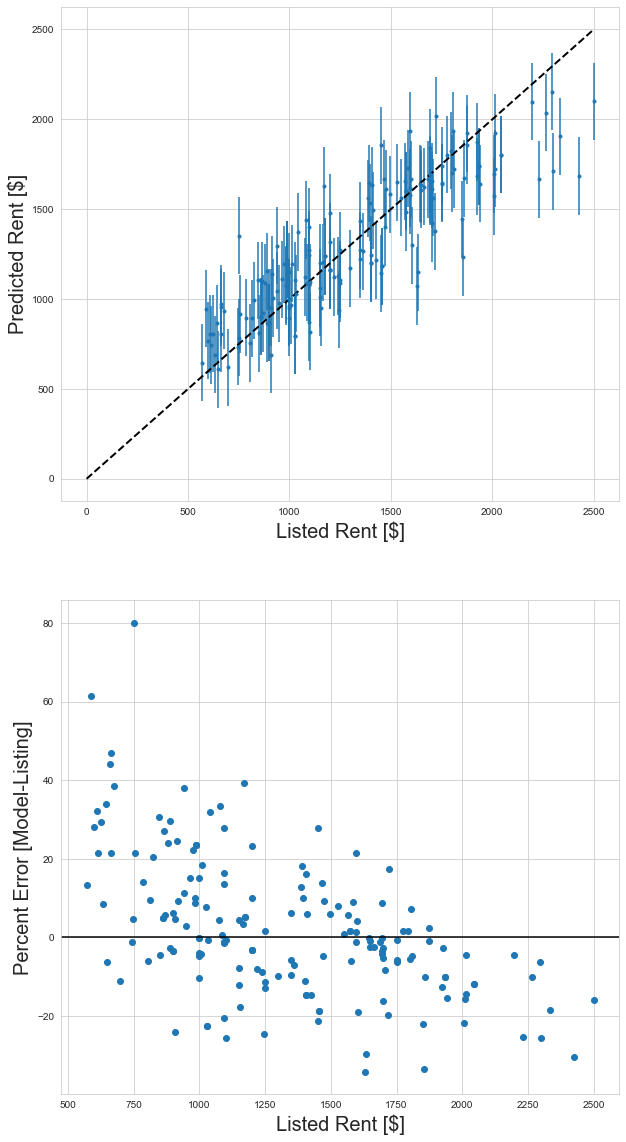

In [27]:
fig, axs = plt.subplots(2,1, figsize=(10,20))
plt.rc('axes', labelsize=20)
axs[0].errorbar(y_test, predicted, yerr=model_var**0.5, linestyle="", marker=".")
axs[0].plot(range(2500), range(2500), linestyle="--", linewidth="2", color="k")
axs[0].set_xlabel("Listed Rent [$]")
axs[0].set_ylabel("Predicted Rent [$]")

axs[1].scatter(y_test, (predicted-y_test)*100/y_test)
axs[1].set_xlabel("Listed Rent [$]")
axs[1].set_ylabel("Percent Error [Model-Listing]")
axs[1].axhline(0, c="k")


In [31]:
np.average(abs(predicted-y_test)*100/y_test)

13.27552948492316